# Qiskit SAT Synthesis

* **Using SAT-solver (namely Z3) to find depth- and count- optimal circuits for linear functions, cliffords, permutations, GHZ states, and more.**

* Alexander Ivrii: alexi@il.ibm.com


---
This notebook covers how to use the Qsikit-Sat-Synthesis package. 
* Level 1: Running synthesis methods via Qiskit high-level-synthesis transpiler plugins.
* Level 2: Running synthesis methods directly.
* Level 3: Building custom problem variants.
* Level 4: Extending existing problem classes and creating new ones.

### Includes

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
!pip install qiskit-sat-synthesis 

In [41]:
import numpy as np

# Qiskit includes
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import LinearFunction, PermutationGate
from qiskit.quantum_info import Clifford
from qiskit.transpiler import CouplingMap
from qiskit.compiler import transpile
from qiskit.transpiler.passes.synthesis.high_level_synthesis import HLSConfig
from qiskit.transpiler.passes import HighLevelSynthesis

# Level I: Running synthesis methods via Qiskit high-level-synthesis transpiler plugins

The simplest way to use the provided synthesis methods is via Qiskit's high-level-synthesis plugin interface. After installing the package, one should see the plugin names "sat_depth" and "sat_count" for cliffords, linear functions and permutations.


#### Listing available plugins

In [42]:
from qiskit.transpiler.passes.synthesis import high_level_synthesis_plugin_names
print(f'Clifford plugin names: {high_level_synthesis_plugin_names("clifford")}')
print(f'LinearFunction plugin names: {high_level_synthesis_plugin_names("linear_function")}')
print(f'PermutationGate plugin names: {high_level_synthesis_plugin_names("permutation")}')

Clifford plugin names: ['ag', 'bm', 'default', 'greedy', 'layers', 'lnn', 'sat_count', 'sat_depth']
LinearFunction plugin names: ['default', 'kms', 'pmh', 'sat_count', 'sat_depth']
PermutationGate plugin names: ['acg', 'basic', 'default', 'kms', 'token_swapper', 'sat_count', 'sat_depth']


#### Quantum circuit example

Let us create a quantum circuit with a single linear function.

In [43]:
mat = np.array(
    [
        [1, 1, 0, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1],
        [1, 0, 1, 1, 0],
    ]
)
mat

array([[1, 1, 0, 1, 1],
       [0, 1, 1, 1, 1],
       [0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 1, 1, 0]])

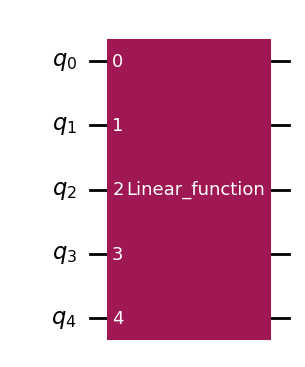

In [45]:
qc = QuantumCircuit(5)
qc.append(LinearFunction(mat), [0, 1, 2, 3, 4])
qc.draw("mpl")

#### Transpile using "default" synthesis

ops: OrderedDict({'cx': 8}), depth: 6


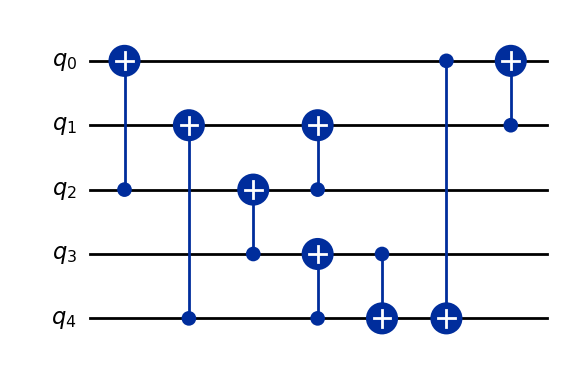

In [46]:
# Transpile (default)

tqc = transpile(qc)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Transpile using sat_count

ops: OrderedDict({'cx': 8, 'barrier': 8}), depth: 8


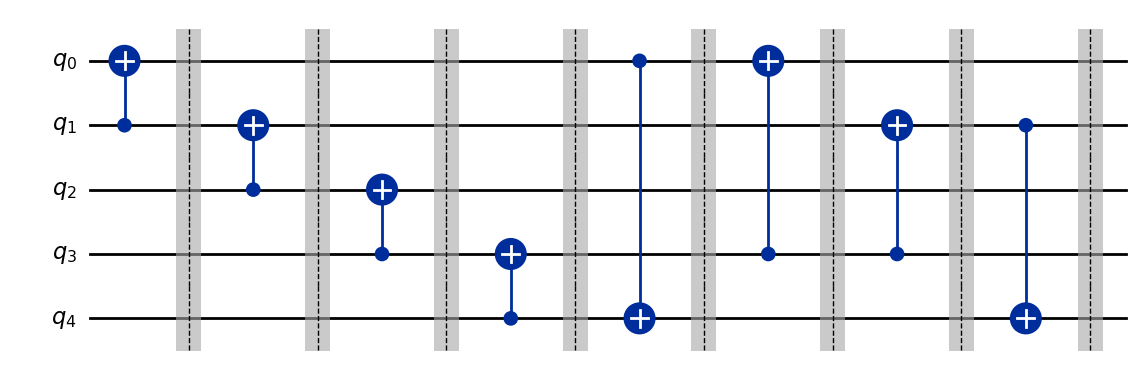

In [7]:
hls_config = HLSConfig(linear_function=[("sat_count", {})])
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Transpile using sat_depth

ops: OrderedDict({'cx': 9, 'barrier': 5}), depth: 5


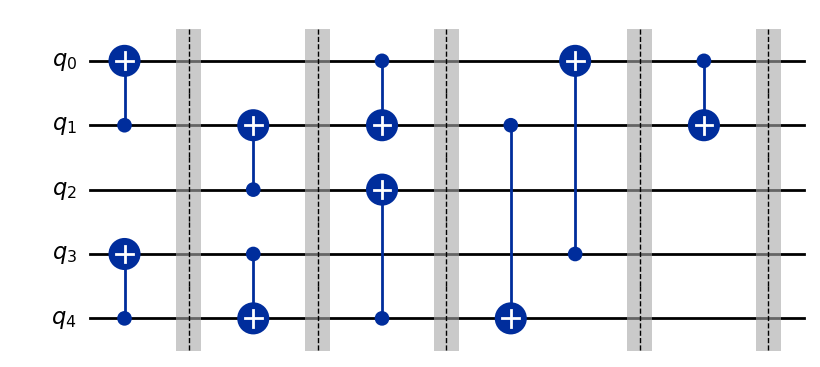

In [8]:
hls_config = HLSConfig(linear_function=[("sat_depth", {})])
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Specifying additional options

The "sat_depth" and "sat_count" plugins have a large number of additional options. The following example additionally optimizes the number of CX gates for the minimum depth, and increases the debug output verbosity.

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = False
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 25,  #clauses = 50,  #assumptions = 0
 => sat-solver result: unsat in 0.0 s
 => synthesis problem result: no solutions in 0.0 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 115,  #clauses = 856,  #assumptions = 0
 => sat-solver result: unsat in 0.07 s
 => synthesis problem result: no solutions in 0.07 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 225,  #clauses = 1812,  #assumptions = 0
 => sat-solver result: unsat in 0.15 s
 => synthesis problem result: no solutions in 0.15 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 325,  #clauses = 2738,  #assumptions = 0
 => sat-

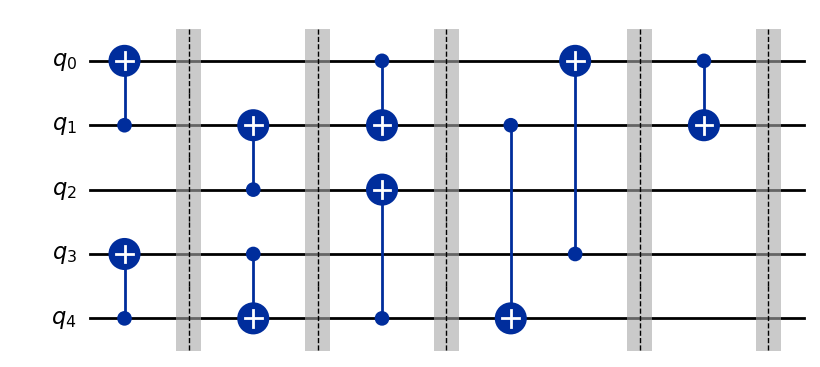

In [9]:
hls_config = HLSConfig(
    linear_function=[("sat_depth", {"optimize_1q_gates": True, "verbosity": 1})]
)
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Synthesis "up to permutation on the output qubits"

ops: OrderedDict({'cx': 7, 'barrier': 4}), depth: 4


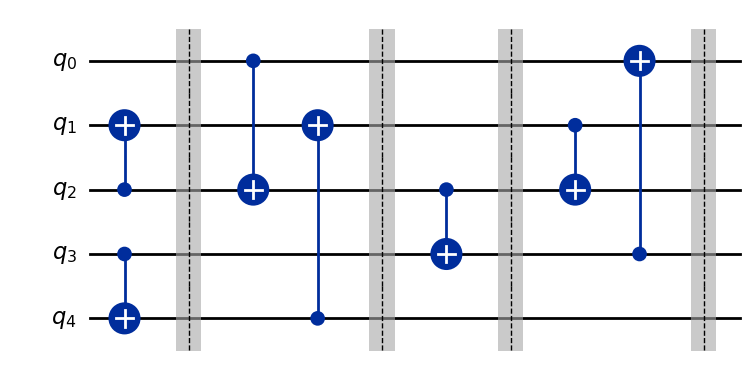

In [10]:
hls_config = HLSConfig(linear_function=[("sat_depth", {"allow_final_permutation": True})])
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

Note: the final permutation is currently not returned, but in principle can be returned via circuit's metadata

#### Synthesis "up to layout permutation"

ops: OrderedDict({'cx': 9, 'barrier': 5}), depth: 5


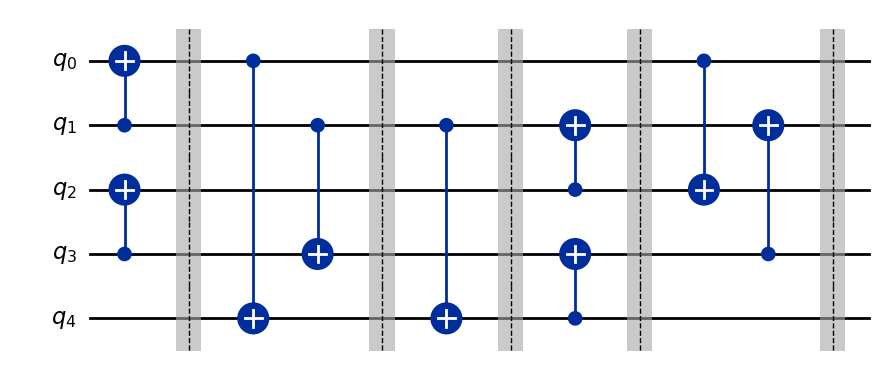

In [11]:
hls_config = HLSConfig(linear_function=[("sat_depth", {"allow_layout_permutation": True})])
tqc = transpile(qc, hls_config=hls_config)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Specifying coupling map

The plugins work with arbitrary coupling maps. The easiest way to specify them via Qiskit is to use `HighLevelSynthesis` transpiler pass rather than `transpile` function.

ops: OrderedDict({'cx': 20, 'barrier': 10}), depth: 10


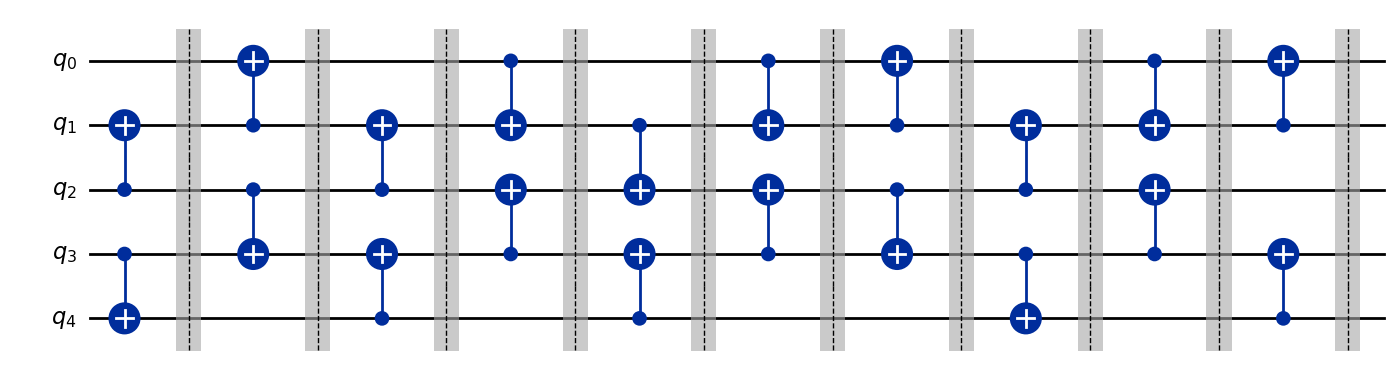

In [12]:
hls_config = HLSConfig(linear_function=[("sat_depth", {})])
coupling_map = CouplingMap.from_line(5)
tqc = HighLevelSynthesis(hls_config=hls_config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Another example: synthesing cyclic shift permutations

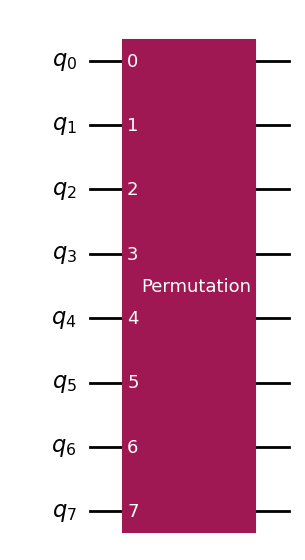

In [13]:
# This is cyclic shift: 1->0, 2->1, 0->2

pattern = [1, 2, 3, 4, 5, 6, 7, 0]
qc = QuantumCircuit(8)
qc.append(PermutationGate(pattern), [0, 1, 2, 3, 4, 5, 6, 7])
qc.draw(output='mpl')

#### Using full connectivity

ops: OrderedDict({'swap': 7, 'barrier': 2}), depth: 2


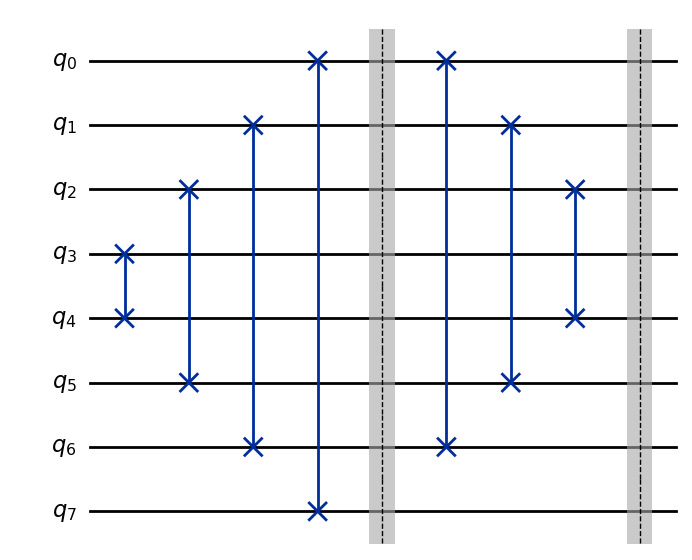

In [14]:
hls_config = HLSConfig(permutation=[("sat_depth", {"optimize_2q_gates": True})])
coupling_map = CouplingMap.from_full(8)
tqc = HighLevelSynthesis(hls_config=hls_config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Using line connectivity

ops: OrderedDict({'swap': 7, 'barrier': 7}), depth: 7


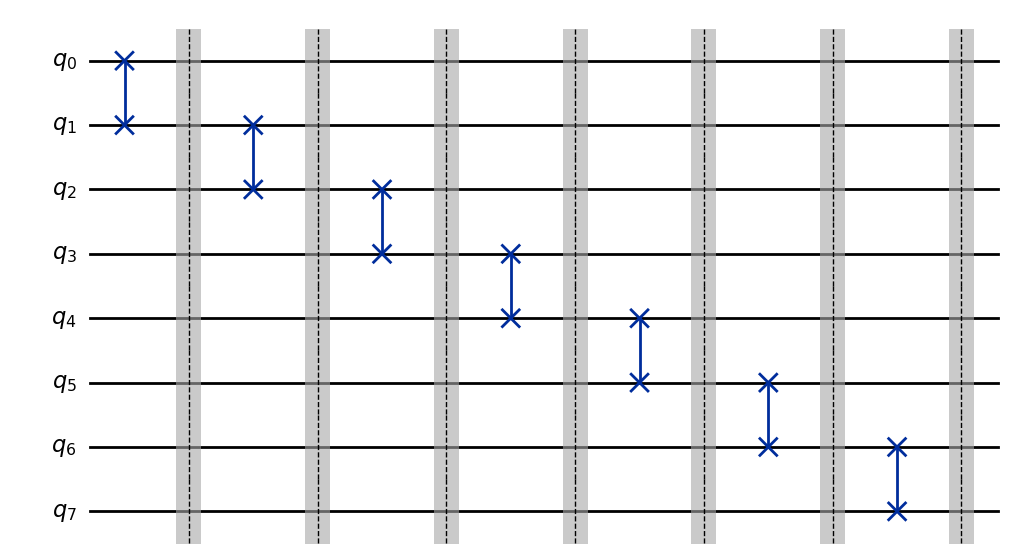

In [15]:
hls_config = HLSConfig(permutation=[("sat_depth", {"optimize_2q_gates": True})])
coupling_map = CouplingMap.from_line(8)
tqc = HighLevelSynthesis(hls_config=hls_config, coupling_map=coupling_map, use_qubit_indices=True)(qc)
print(f"ops: {tqc.count_ops()}, depth: {tqc.depth()}")
tqc.draw("mpl")

#### Other options

There are many other options: specifying min and max depth for the search, optimizing the number of 2q and 1q gates, specifying time-limits and call-limits on each call to the SAT-solver, and more.

# Level 2: Running synthesis methods directly

The high-level-synthesis plugins considered before are built on top of the following synthesis functions implemented in the package: `synthesize_linear_count`, `synthesize_linear_depth`, `synthesize_permutation_count`, `synthesize_permutation_depth`, `synthesize_clifford_count`, `synthesize_clifford_depth`, `synthesize_superposed_depth`.

Even though most of the functionality is exposed via the plugin interface, in certain cases working with the synthesis functions directly can be useful and offers a bit more flexibility. This includes:
* Synthesis methods for objects not available in Qiskit (e.g. synthesis of GHZ states, here called _superposed_ states)
* Retrieving permutations used when "allow_layout_permutation" or "allow_final_permutation" (or both) are True
* Examining multiple solutions
* Specifying multiple coupling maps

#### Example: synthesizing matrices (aka linear functions)

In [16]:
print(mat)

[[1 1 0 1 1]
 [0 1 1 1 1]
 [0 0 1 1 0]
 [0 0 0 1 1]
 [1 0 1 1 0]]


In [17]:
from qiskit_sat_synthesis.synthesize_linear import synthesize_linear_depth, synthesize_linear_count

line5 = list(CouplingMap.from_line(5).get_edges())  # line connectivity
full5 = list(CouplingMap.from_full(5).get_edges())  # all-to-all connectivity

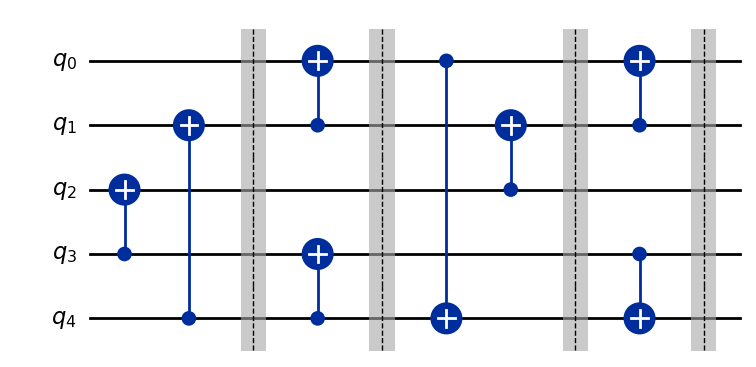

In [18]:
res = synthesize_linear_depth(mat, coupling_map=full5, verbosity=0, allow_final_permutation=True)
res.circuit.draw("mpl")

#### Displaying circuit with permutations

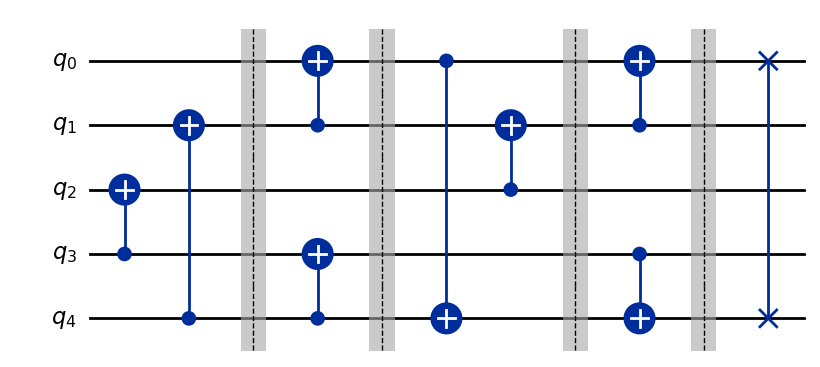

In [19]:
res.circuit_with_permutations.draw(output='mpl')

In [20]:
print(res.solutions[0].final_permutation)

[4, 1, 2, 3, 0]


#### Checking the result

In [21]:
LinearFunction(res.circuit_with_permutations) == LinearFunction(mat)

np.True_

#### Multiple solutions

In [22]:
res = synthesize_linear_depth(mat, coupling_map=full5, verbosity=1, allow_final_permutation=True, print_solutions=False, max_solutions=5)

Running linear synthesis with options: optimize depth2q, allow_layout_permutation = False, allow_final_permutation = True
Looking for solution with target depth 0
 => synthesis problem has 0 layers
 => running sat-solver: #vars = 125,  #clauses = 440,  #assumptions = 0
 => sat-solver result: unsat in 0.03 s
 => synthesis problem result: no solutions in 0.03 s 
Looking for solution with target depth 1
 => synthesis problem has 1 layers
 => running sat-solver: #vars = 215,  #clauses = 1246,  #assumptions = 0
 => sat-solver result: unsat in 0.1 s
 => synthesis problem result: no solutions in 0.1 s 
Looking for solution with target depth 2
 => synthesis problem has 2 layers
 => running sat-solver: #vars = 325,  #clauses = 2202,  #assumptions = 0
 => sat-solver result: unsat in 0.18 s
 => synthesis problem result: no solutions in 0.18 s 
Looking for solution with target depth 3
 => synthesis problem has 3 layers
 => running sat-solver: #vars = 425,  #clauses = 3128,  #assumptions = 0
 => sa

In [23]:
for i, solution in enumerate(res.solutions):
    print(f"Solution {i+1}:")
    print(solution.circuit)

Solution 1:
                ░ ┌───┐ ░            ░ ┌───┐ ░ 
q_0: ───────────░─┤ X ├─░───■────────░─┤ X ├─░─
          ┌───┐ ░ └─┬─┘ ░   │  ┌───┐ ░ └─┬─┘ ░ 
q_1: ─────┤ X ├─░───■───░───┼──┤ X ├─░───■───░─
     ┌───┐└─┬─┘ ░       ░   │  └─┬─┘ ░       ░ 
q_2: ┤ X ├──┼───░───────░───┼────■───░───────░─
     └─┬─┘  │   ░ ┌───┐ ░   │        ░       ░ 
q_3: ──■────┼───░─┤ X ├─░───┼────────░───■───░─
            │   ░ └─┬─┘ ░ ┌─┴─┐      ░ ┌─┴─┐ ░ 
q_4: ───────■───░───■───░─┤ X ├──────░─┤ X ├─░─
                ░       ░ └───┘      ░ └───┘ ░ 
Solution 2:
           ░            ░ ┌───┐      ░            ░ 
q_0: ──■───░────────────░─┤ X ├──────░───■────────░─
     ┌─┴─┐ ░            ░ └─┬─┘      ░   │  ┌───┐ ░ 
q_1: ┤ X ├─░───■────────░───┼────────░───┼──┤ X ├─░─
     └───┘ ░   │  ┌───┐ ░   │  ┌───┐ ░   │  └─┬─┘ ░ 
q_2: ──■───░───┼──┤ X ├─░───┼──┤ X ├─░───┼────■───░─
     ┌─┴─┐ ░   │  └─┬─┘ ░   │  └─┬─┘ ░   │        ░ 
q_3: ┤ X ├─░───┼────■───░───■────┼───░───┼────────░─
     └───┘ ░ ┌─┴─┐      

#### Example: synthesizing GHZ (superposed) states

At the moment, Qiskit does not contains a high-level-object corresponding to a GHZ state

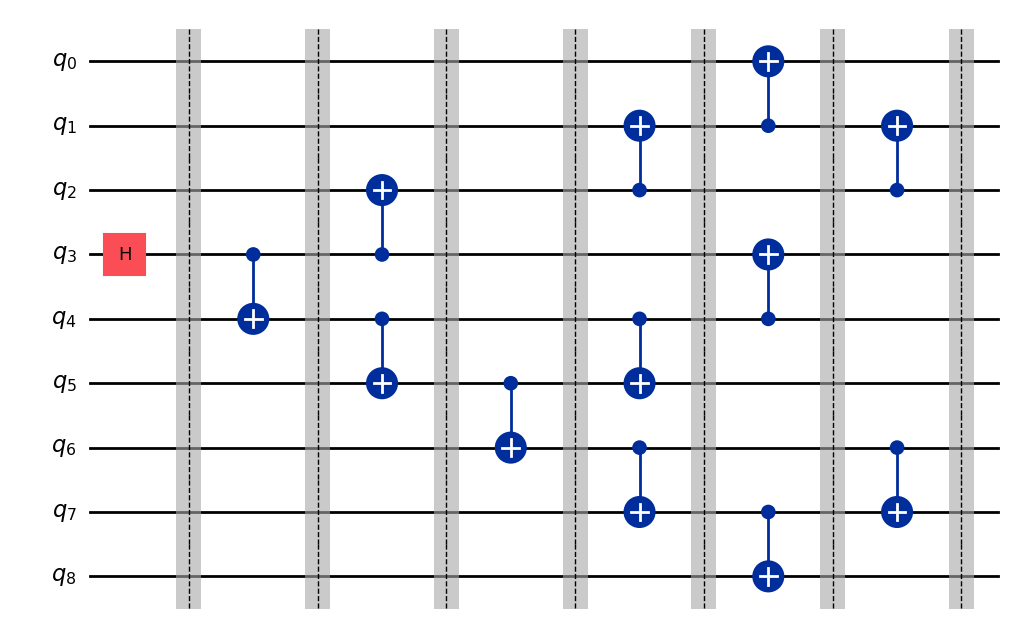

In [24]:
from qiskit_sat_synthesis.synthesize_superposed import (
    synthesize_superposed_count,
    synthesize_superposed_depth,
)

coupling_map = [(0, 1), (1, 0), (1, 2), (2, 1), (2, 3), (3, 2), (3, 4), (4, 3), (4, 5), (5, 4), (5, 6), (6, 5), (6, 7), (7, 6), (7, 8), (8, 7)]  # line connectivity

result = synthesize_superposed_depth(
    [1, 0, 1, 0, 1, 0, 1, 0, 1],
    coupling_map=coupling_map,
    optimize_2q_gates=True,
    print_solutions=False,
    verbosity=0,
    max_depth2q=10,
)

result.circuit.draw('mpl')

#### Multiple coupling maps

There is also an option to specify multiple coupling maps, with the condition that every layer must conform to one of these maps. The following example considers the connectivity of the 3x3 grid and differentiates between horizontal and vertical edges.

In [25]:
hor9 = [[0, 1], [3, 4], [6, 7], [1, 0], [4, 3], [7, 6], [1, 2], [4, 5], [7, 8], [2, 1], [5, 4], [8, 7]]
ver9 = [[0, 3], [1, 4], [2, 5], [3, 0], [4, 1], [5, 2], [3, 6], [4, 7], [5, 8], [6, 3], [7, 4], [8, 5]]
all9 = hor9 + ver9

state = [1, 0, 0, 0, 0, 0, 0, 0, 1]

#### Allowing all edges

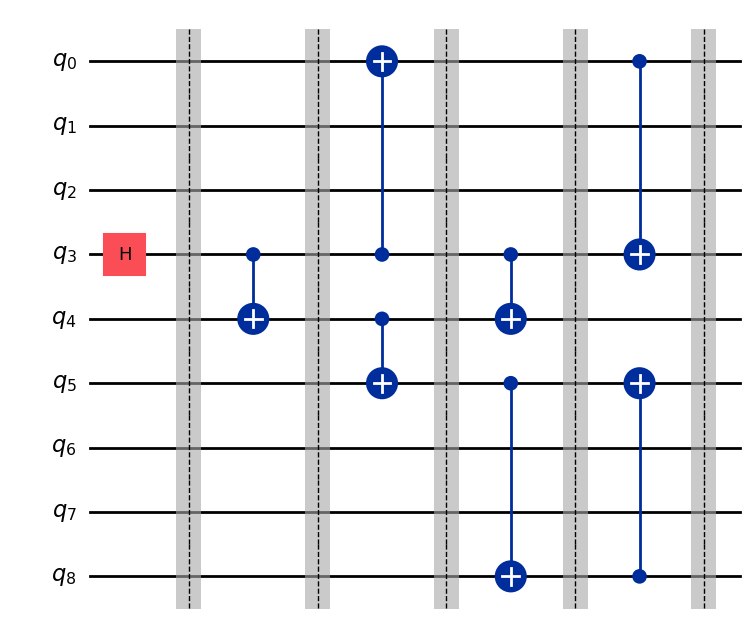

In [26]:
res = synthesize_superposed_depth(
    state,
    coupling_map=all9,
    print_solutions=False,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=0,
)
res.circuit.draw(output='mpl')

#### Requiring that every layer is either horizonal or vertical

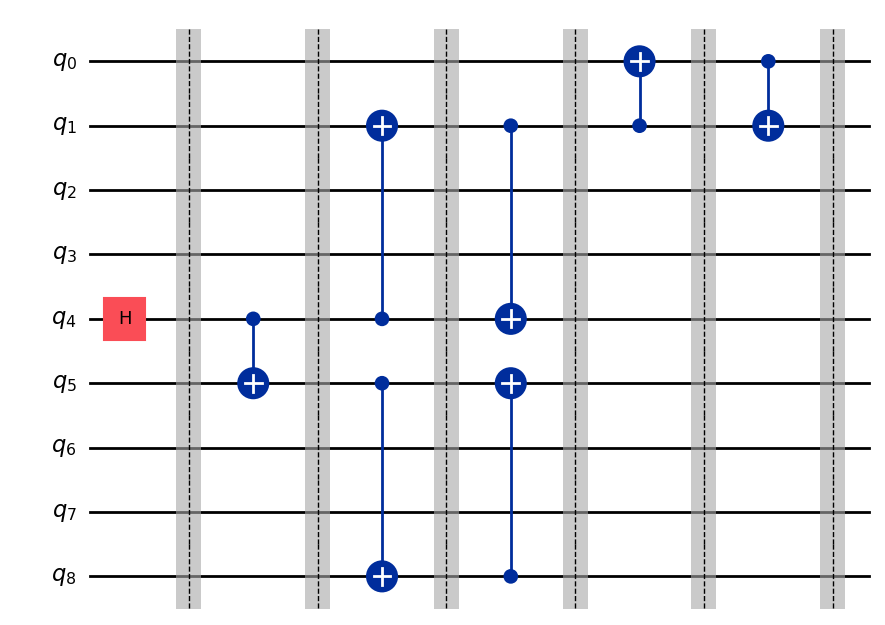

In [27]:
res = synthesize_superposed_depth(
    state,
    coupling_map_list=[hor9, ver9],
    print_solutions=False,
    check_solutions=True,
    optimize_2q_gates=True,
    verbosity=0,
)
res.circuit.draw(output='mpl')

By requiring that every layer in the solution must be either horizonal or vertical, the optimum depth has increased from 4 to 5.

# Level 3: Building custom problem variants

Sometimes we might be interested to synthesize the objects that are already supported (such as Cliffords, linear matrices or permutations), but we want to explore the functionality not directly available by the prepacked functions `synthesize_linear_count`, etc. For example, we might want to manually fix some of the gates or impose additional or different constraints. 

Let us first explain what happens under the hood. 

In a nutshell, given some number `k` of layers, we consider a problem such as _"Does there exist a circuit with at most `k` layers of CX-gates that implements a given linear matrix"_. We translate this problem to CNF, and call the SAT-solver (Z3). The SAT-solver returns whether the given problem is _satisfiable_ (has a solution), _unsatisfiable_ (has no solution), or _unknown_ (a resource limit such as _timeout_ or _max\_conflicts_ has been reached). We are interested in the smallest value of `k` for which the problem is satisfiable. The available method `synthesize_optimal` implements the "bottom-up" approach: the value of `k` is initially `0`, and is increased by `1` when the problem is unsatisfiable. In this way, the first satisfiable solution will neccessarily have the smallest number of layers.

We can create _custom_ linear (and also clifford, permutation, GHZ, etc.) problems by specifying and restricting layers in the solution, and adding various constraints that involve one or more layers. The constraints might for example say that _"a given gate in the given layer must be a Hadamard gate"_, or correspond to various search-space reduction constraints, such as: _"for depth-optimal synthesis do not allow solutions where some CX-gate can be moved to the previous layer"_, _"do not allow solutions with two consecutive CX gates over the same pair of qubits"_, or _"when a CX(i, j) gate is followed by a CX(i, k) gate, assume that `j<k`"_. It is up to the user to make sure that the added constraints are mutually consistent.

#### Example: specifying both initial and final matrices

Suppose we want to find a linear circuit (consisting of CX-gates only) that brings one given matrix matrix `mat1` into another given matrix `mat2` and conforms to the linear-nearest neighbor connectivity. In other words, we want to create a variant of the linear synthesis problem with the constraint that the initial matrix is `mat1` rather than the identity. While our problem can be easily reduced to the "standard" problem (that searches a linear circuit from the identity to `mat2 * mat1^{-1}`), let us show how to create and solve this problem directly.

For simplicity, let's suppose that `mat1` and `mat2` are as follows.

In [28]:
mat1 = np.array(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [1, 1, 1, 1],
    ]
)

mat2 = np.array(
    [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [1, 0, 1, 0],
        [1, 1, 1, 1],
    ]
)

We now create a "custom problem": a function that takes in a single parameter `k` and outputs a `SatProblemLinear` instance with `k` layers. The problem is constructed by adding layers, each layer consisting of CX gates, and adhering to the linear coupling map. We restrict the initial matrix to `mat` using `set_init_matrix` function, and the final matrix to `mat2` using `set_final_matrix`. We can optionally set the option to minimize the number of 2-qubit gates once the optimum depth is found. 

In [29]:
from qiskit_sat_synthesis.sat_problem_linear import SatProblemLinear
def create_custom_problem(k):
    nq = 4
    coupling_map = [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2]]
    sat_problem = SatProblemLinear(nq, verbosity=0)
    sat_problem.set_init_matrix(mat1)
    for _ in range(k):
        sat_problem.add_layer(
            gates=["CX"],
            coupling_maps=[coupling_map],
        )
    sat_problem.set_final_matrix(mat2)
    sat_problem.set_optimize_2q_gate(True)
    return sat_problem

Now we run the `synthesis_optimal` method that takes in `create_sat_problem_fn`.

In [30]:
from qiskit_sat_synthesis.synthesize import SynthesisResult, synthesize_optimal
res = synthesize_optimal(create_sat_problem_fn=create_custom_problem, verbosity=1)

Looking for solution with target depth 0
Looking for solution with target depth 1
Looking for solution with target depth 2
Looking for solution with target depth 3
Looking for solution with target depth 4
Synthesis summary: found solution at depth 4 in 0.24 s; num_1q = 0; num_2q = 4


In [31]:
print(res.circuit)

           ░       ░       ░       ░ 
q_0: ──■───░───────░───■───░───────░─
     ┌─┴─┐ ░       ░ ┌─┴─┐ ░       ░ 
q_1: ┤ X ├─░───■───░─┤ X ├─░───■───░─
     └───┘ ░ ┌─┴─┐ ░ └───┘ ░ ┌─┴─┐ ░ 
q_2: ──────░─┤ X ├─░───────░─┤ X ├─░─
           ░ └───┘ ░       ░ └───┘ ░ 
q_3: ──────░───────░───────░───────░─
           ░       ░       ░       ░ 


#### Another example: allowing both CX and SWAP gates

As another example, suppose that we want to create a variant of `SatProblemLinear` where a circuit can consist of both `CX` and `SWAP` gates. Suppose that we want to minimize the 2-qubit depth of such a circuit (where the depth of every 2-qubit gate is counted as `1`). 

In [32]:
def create_cx_swap_problem(k, mat):
    nq = len(mat)
    coupling_map = list(CouplingMap.from_line(nq).get_edges())
    sat_problem = SatProblemLinear(nq, verbosity=0)
    sat_problem.set_init_matrix_to_identity(nq)
    for _ in range(k):
        sat_problem.add_layer(
            gates=["CX", "SWAP"],
            coupling_maps=[coupling_map],
        )
    sat_problem.set_final_matrix(mat)
    return sat_problem

In [33]:
mat = np.array(
    [
        [1, 1, 0, 1, 1],
        [0, 1, 1, 1, 1],
        [0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1],
        [1, 0, 1, 1, 0],
    ]
)

Looking for solution with target depth 0
Looking for solution with target depth 1
Looking for solution with target depth 2
Looking for solution with target depth 3
Looking for solution with target depth 4
Looking for solution with target depth 5
Looking for solution with target depth 6
Looking for solution with target depth 7
Synthesis summary: found solution at depth 7 in 1.36 s; num_1q = 0; num_2q = 14


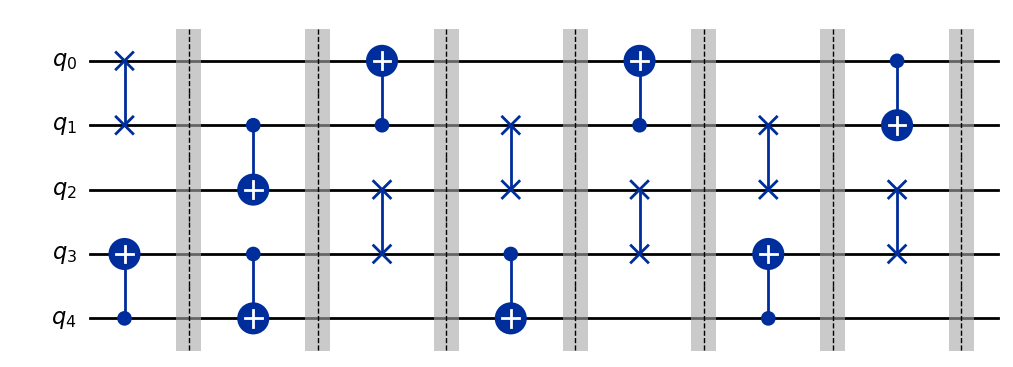

In [34]:
from functools import partial

res = synthesize_optimal(
    create_sat_problem_fn=partial(create_cx_swap_problem, mat=mat), verbosity=1
)

res.circuit.draw(output='mpl')

In [35]:
print(LinearFunction(res.circuit) == LinearFunction(mat))

True


#### Constraints

There is also a large pool of available ad-hoc constraints that we could add to the problem to further reduce the search space. For example, we could explicitly add constraints that every layer in the problem is non-empty (i.e. includes at least one gate).

Looking for solution with target depth 0
Looking for solution with target depth 1
Looking for solution with target depth 2
Looking for solution with target depth 3
Looking for solution with target depth 4
Looking for solution with target depth 5
Looking for solution with target depth 6
Looking for solution with target depth 7
Synthesis summary: found solution at depth 7 in 1.33 s; num_1q = 0; num_2q = 14


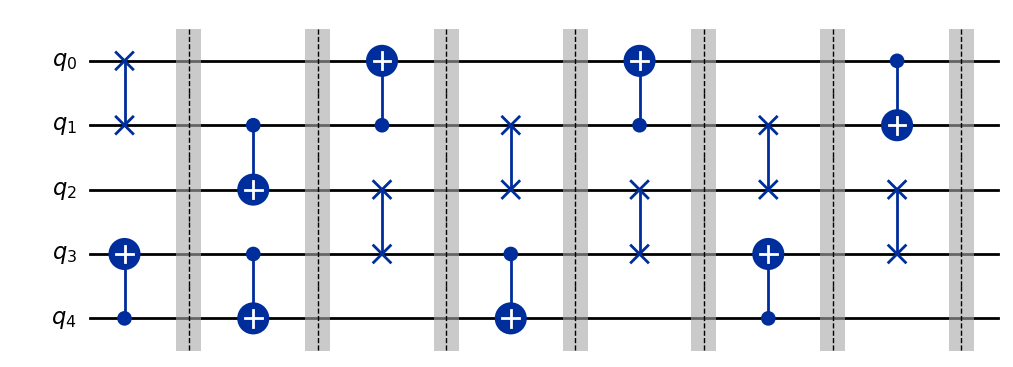

In [36]:
def create_cx_swap_problem(k, mat):
    nq = len(mat)
    coupling_map = list(CouplingMap.from_line(nq).get_edges())
    sat_problem = SatProblemLinear(nq, verbosity=0)
    sat_problem.set_init_matrix_to_identity(nq)
    for _ in range(k):
        layer_id = sat_problem.add_layer(gates=["CX", "SWAP"], coupling_maps=[coupling_map])
        sat_problem.add_nonempty_constraint(layer_id)
    sat_problem.set_final_matrix(mat)
    return sat_problem

res = synthesize_optimal(
    create_sat_problem_fn=partial(create_cx_swap_problem, mat=mat), verbosity=1
)

res.circuit.draw(output='mpl')

Technically speaking, these constraints are redundant: a minimum-depth solution will not have empty layers. However, adding such constraints explicitly may speed up the SAT search by preventing the SAT solver from exploring parts of the search space without solutions.

# Level 4: Extending existing problem classes and creating new ones

Internally, the class `SatProblemLinear` models linear circuits using `n x n` binary matrices and describes how these matrices change when applying a gate or a layer of gates. Of course, not every problem can be modeled in this exact way. Clifford problems are modeled using `2n x 2n` binary symplectic matrices (the phase variables can be ignored as they can be easily reconstructed as the very end). On the other hand, GHZ state preparation problems can be modeled in a significantly simpler way using binary vectors of length `n`, making them more scalable for SAT. This is why we have different classes `SatProblemClifford`, `SatProblemPermutation`, `SatProblemSuperposed` and more.

All of the above classes derive from the "base class" `SatProblem`. The idea is that `SatProblem` should be as generic as possible, while its subclasses implement problem-specific functionality. Specifically, `SatProblemLinear` implements the methods `_create_state_vars` (that describes the "state" of the computation initially and after each layer of gates; in our case the "state" is a `n x n` binary matrix), `_encode_init_constraint` (that encodes the constraints on the initial state, e.g. it should be the identity matrix), `_encode_2q_gate` (that describes how the state of the computation changes after applying a given 2-qubit gate), and a few other methods. It is more than likely that in the future `SatProblem` will be extended with more general functionality/constraints and that `SatProblemLinear` will be extended with additional functionality/constraints specific to linear problems. It is also likely that we will need new problem classes for problems that can't be modeled using the classes that we already have.